In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter

# Get input for model training and validation
data_set = pd.read_csv('steam-cleaned.csv')
data_array = data_set.values
input_array = data_array[:, 1:10]
output_array = data_array[:, 10]

# Split data into train and validation sets, then each set into input and labels (referred to as output here)
validation_size = 0.20
input_train, input_validation, output_train, output_validation = model_selection.train_test_split(input_array, output_array, test_size=validation_size, random_state=42)

In [2]:
# List of models we'll use
models = [('LR', LogisticRegression(solver='liblinear')), ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()), ('RFC', RandomForestClassifier()),
          ('MLP', MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000))]

simplefilter(action='ignore', category=FutureWarning)  # Otherwise output is clouded with future warnings

# K-fold cross-validation with k=10 to evaluate the models using training data
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    cv_results = model_selection.cross_val_score(model, input_train, output_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())  # Display both the mean and standard deviation of the accuracy score
    print(msg)

LR: 0.806279 (0.006543)


KNN: 0.773038 (0.023732)
CART: 0.810203 (0.006777)


NB: 0.803924 (0.006646)


RFC: 0.810342 (0.007007)


MLP: 0.808218 (0.007559)


In [3]:
# LR, CART, RFC, MLP are all viable options with sufficiently high accuracies
# We'll feed the validation data into RFC and print out the accuracy score, confusion matrix, and classification report
rfc = RandomForestClassifier()
rfc.fit(input_train, output_train)
predictions = rfc.predict(input_validation)
print(accuracy_score(output_validation, predictions))
print(confusion_matrix(output_validation, predictions))
print(classification_report(output_validation, predictions))

0.8158818097876269
[[2343  326]
 [ 671 2075]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.82      2669
           1       0.86      0.76      0.81      2746

    accuracy                           0.82      5415
   macro avg       0.82      0.82      0.82      5415
weighted avg       0.82      0.82      0.82      5415



In [4]:
# The model performs decently with unseen data, with good accuracy score, precision, and recall
# Next step is algorithm tuning, done with help from All Things AI (https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)
# We will use area under curve to evaluate performance

# Import things we need
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import roc_curve, auc
import numpy as np

# Calculate the baseline performance using this method
false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.8167507245799402


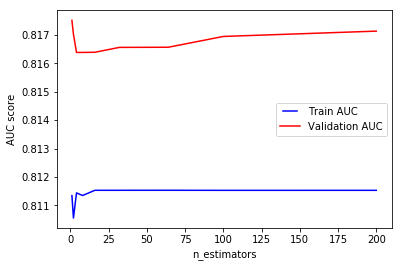

In [5]:
# Tune the number of trees in our forest to see if we can get a better AUC
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]  # Number of trees over a wide range

# For AUC obtained from train set & validation set
train_results = []
validation_results = []

for estimator in n_estimators:
    rfc = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rfc.fit(input_train, output_train)
    train_predictions = rfc.predict(input_train)
    
    # Calculate and add AUC result to the train list
    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_train, train_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    validation_predictions = rfc.predict(input_validation)
    
    # Calculate and add AUC result to the validation set
    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, validation_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    validation_results.append(roc_auc)

# Visualize everything
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, validation_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

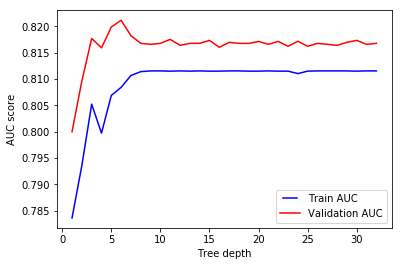

In [6]:
# There's not a huge difference between the train & test curves (difference of roughly 0.005 in score)
# Performance seems to decrease after around n_estimators = 64, so we will choose this value

# Next we will tune the depth of the trees in our forest
max_depths = np.linspace(1, 32, 32, endpoint=True)  # Range of depth tested from 1 to 32

train_results.clear()
validation_results.clear()

# Just like before, but with max_depths param instead
for max_depth in max_depths:
    rfc = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rfc.fit(input_train, output_train)
    train_predictions = rfc.predict(input_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_train, train_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    validation_predictions = rfc.predict(input_validation)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, validation_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    validation_results.append(roc_auc)


line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, validation_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

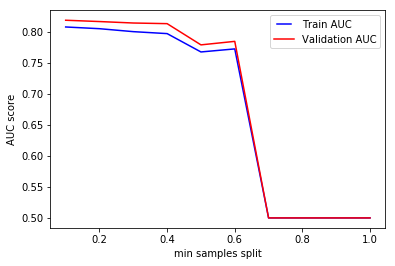

In [7]:
# Again the train & validation curves are quite similar, so there's not much overfitting seen here, even for large values of max_depth
# We can choose max_depth=10 but I think other values >10 would do fine as well

# Now let's tune the min #samples needed to split an internal node
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)  # Range from 10% to 100% of samples

train_results.clear()
validation_results.clear()

# Same as before, but with min_samples_split param
for min_samples_split in min_samples_splits:
    rfc = RandomForestClassifier(min_samples_split=min_samples_split)
    rfc.fit(input_train, output_train)
    train_predictions = rfc.predict(input_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_train, train_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    validation_predictions = rfc.predict(input_validation)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, validation_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    validation_results.append(roc_auc)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, validation_results, 'r', label="Validation AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

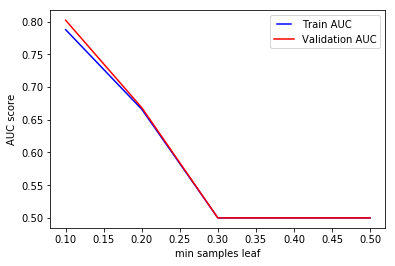

In [8]:
# Performance seems to decrease with higher values of the param, so we can pick 0.1 for this param

# Now tune the min #samples needed in a leaf node
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)  # Range from 10% to 50% of samples

train_results.clear()
validation_results.clear()

# Same as before, but with min_samples_leaf param
for min_samples_leaf in min_samples_leafs:
    rfc = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rfc.fit(input_train, output_train)
    train_predictions = rfc.predict(input_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_train, train_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    validation_predictions = rfc.predict(input_validation)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, validation_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    validation_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, validation_results, 'r', label="Validation AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()

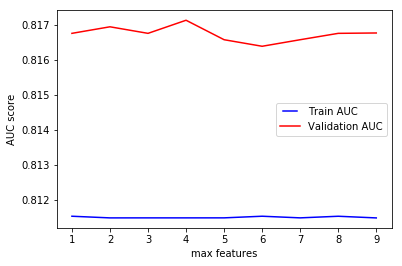

In [9]:
# Similar to min_samples_split, the performance goes down significantly with higher values of the param
# So we can pick 0.1 for this param

# Now let's tune max #features considered when looking for best split
max_features = list(range(1, 10))  # From 1 to max number of features we have (for this data set it's 10)

train_results.clear()
validation_results.clear()

# Same as before but with max_feature param
for max_feature in max_features:
    rfc = RandomForestClassifier(max_features=max_feature)
    rfc.fit(input_train, output_train)
    train_pred = rfc.predict(input_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    validation_predictions = rfc.predict(input_validation)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, validation_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    validation_results.append(roc_auc)

line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, validation_results, 'r', label="Validation AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

In [10]:
# AUC pretty consistent for train results, but varies for validation results
# max_features=2 seems to yield a good AUC for validation and doesn't really affect train, so let's use this value

# Put it all together in a final model
rfc_final = RandomForestClassifier(n_estimators=64, max_depth=10, min_samples_split=0.1, 
                                   min_samples_leaf=0.1, max_features=2)
rfc_final.fit(input_train, output_train)
predictions = rfc_final.predict(input_validation)

# Print all our evaluation metrics
print(accuracy_score(output_validation, predictions))
print(confusion_matrix(output_validation, predictions))
print(classification_report(output_validation, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(output_validation, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.8075715604801478
[[2546  123]
 [ 919 1827]]
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      2669
           1       0.94      0.67      0.78      2746

    accuracy                           0.81      5415
   macro avg       0.84      0.81      0.80      5415
weighted avg       0.84      0.81      0.80      5415

0.8096233576028841


In [11]:
# Results are unfortunately quite similar after tuning compared to before tuning
# Perhaps a different approach to cleaning the data & feature engineering could produce better results
# Or perhaps picking another well-performing algorithm and tuning that one could give more significant differences in results
# In any case these results are still quite satisfactory!